# College Message Dataset


## Reading Data

In [10]:
from typing import NamedTuple
class CollegeMessage(NamedTuple):
    source: int #source id
    target: int # target id
    unix_timestamp: int # seconds after last epoc

Data is stored in a text file with each line containing the source id, target id and the timestamp of the message.

In [11]:
from pathlib import Path
def read_message_data(data_path: str) -> list[CollegeMessage]:
    
    filepath = Path.cwd() / Path(data_path)
    
    if not filepath.exists():
        raise FileNotFoundError(
            f"File not found: {filepath}; " +
            f"Current working directory: {Path.cwd()}; " +
            f"Relative path to data file: {Path(data_path)}"
        )
    
    print(f"Using file: {filepath.absolute()}")
    
    messages = []
    with open(filepath, 'r', encoding="UTF-8") as f:
        for line in f:
            source, target, timestamp = line.strip().split()
            messages.append(CollegeMessage(int(source), int(target), int(timestamp)))
    print("done")
    return messages
    

In [12]:
data_path = "./dataset/CollegeMsg.txt"

MESSAGES = read_message_data(data_path)

Using file: C:\Users\majerm\projects\private\github\rug-sna-pizza-giving\college_msg_files\dataset\CollegeMsg.txt
done


Taking a first glance at raw data in a pandas dataframe

In [13]:
import pandas as pd
raw_data_df = pd.DataFrame(MESSAGES)
raw_data_df.head()


,source,target,unix_timestamp
0,1,2,1082040961
1,3,4,1082155839
2,5,2,1082414391
3,6,7,1082439619
4,8,7,1082439756


## Creating the networkx graph

Function to create a graph from the data

In [14]:
import networkx as nx

def create_graph(data: pd.DataFrame) -> nx.DiGraph:
    G = nx.DiGraph()
    for row in data.itertuples(index=False):
        G.add_edge(row.source, row.target, timestamp=row.unix_timestamp)
    return G


Create the graph

In [15]:
raw_data_graph = create_graph(raw_data_df)

Draw the graph

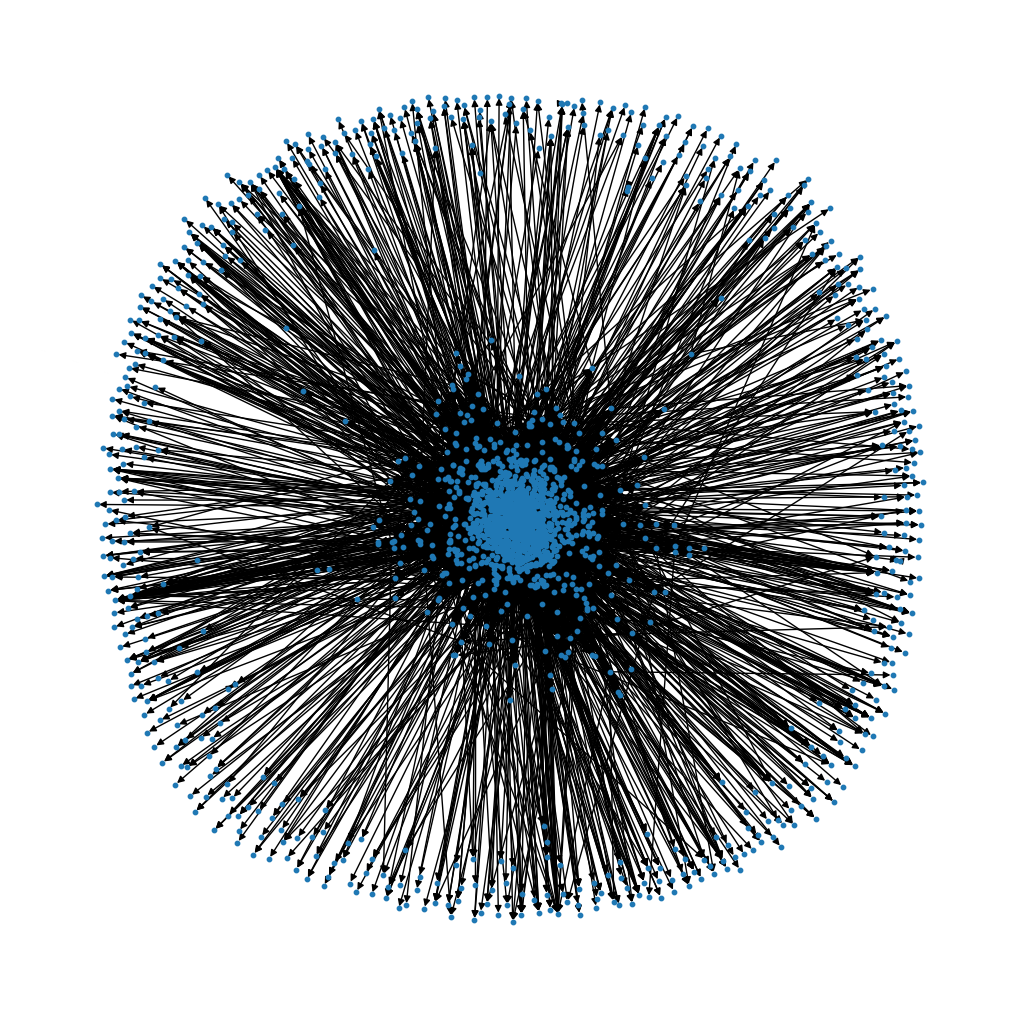

In [16]:
import matplotlib.pyplot as plt

def draw_graph(graph: nx.DiGraph):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=False, node_size=10)
    plt.show()
    
draw_graph(raw_data_graph)

## Metrics

## Calculate metrics of the graph:
 Number of vertices, number of edges, degree distribution (in-degree and out degree), centrality indices, clustering coefficient, network diameter, density, number of connected components and, size of the connected components.

In [17]:
def calculate_metrics(graph: nx.DiGraph):
    metrics = {}
    metrics["number_of_nodes"] = graph.number_of_nodes()
    metrics["number_of_edges"] = graph.number_of_edges()
    metrics["degree_distribution"] = {
        "in_degree": dict(graph.in_degree()),
        "out_degree": dict(graph.out_degree())
    }
    metrics["centrality"] = {
        "in_degree": nx.in_degree_centrality(graph),
        "out_degree": nx.out_degree_centrality(graph),
        "closeness": nx.closeness_centrality(graph),
        "betweenness": nx.betweenness_centrality(graph),
        "eigenvector": nx.eigenvector_centrality(graph)
    }
    metrics["clustering_coefficient"] = nx.average_clustering(graph)
    try:
        metrics["diameter"] = nx.diameter(graph.to_undirected())
    except nx.NetworkXError:
        # Handle the case where the graph is not connected
        metrics["diameter"] = float('inf')  # or any other value to indicate 
    metrics["density"] = nx.density(graph)
    metrics["connected_components"] = {
        "number": nx.number_connected_components(graph.to_undirected()),
        "sizes": [len(c) for c in nx.connected_components(graph.to_undirected())]
    }
    return metrics

In [18]:
raw_data_metrics = calculate_metrics(raw_data_graph)

## Visualizing the metrics

### Number of nodes and edges

In [19]:
print(f"Number of nodes: {raw_data_metrics['number_of_nodes']}")
print(f"Number of edges: {raw_data_metrics['number_of_edges']}")

Number of nodes: 1899
Number of edges: 20296


### Degree distribution
Define in and out degree distribution functions

In [20]:
def calculate_degree_distribution(degree_distribution: dict) -> dict:
    distribution = {}
    for node, degree in degree_distribution.items():
        if degree in distribution:
            distribution[degree] += 1
        else:
            distribution[degree] = 1
    return distribution

def plot_degree_distribution(degree_distribution: dict, title: str):
    plt.figure(figsize=(10, 5))
    plt.bar(degree_distribution.keys(), degree_distribution.values())
    plt.title(title)
    plt.xlabel("Degree")
    plt.ylabel("Number of nodes")
    plt.show()
    


Plot the in and out degree distribution

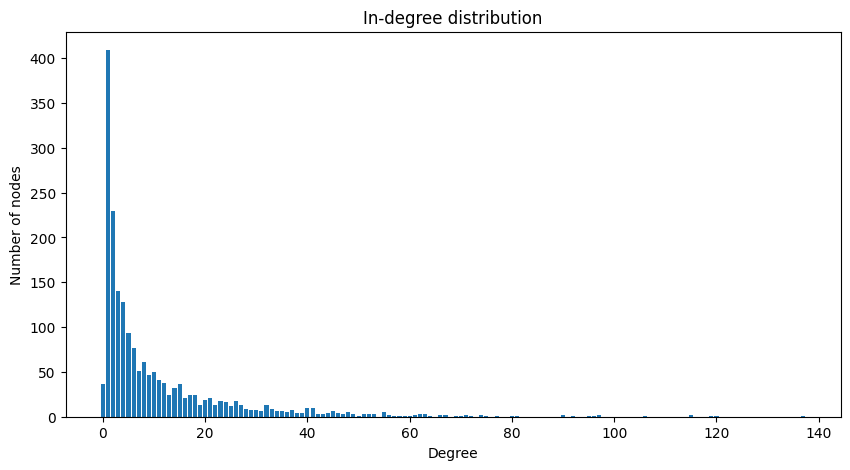

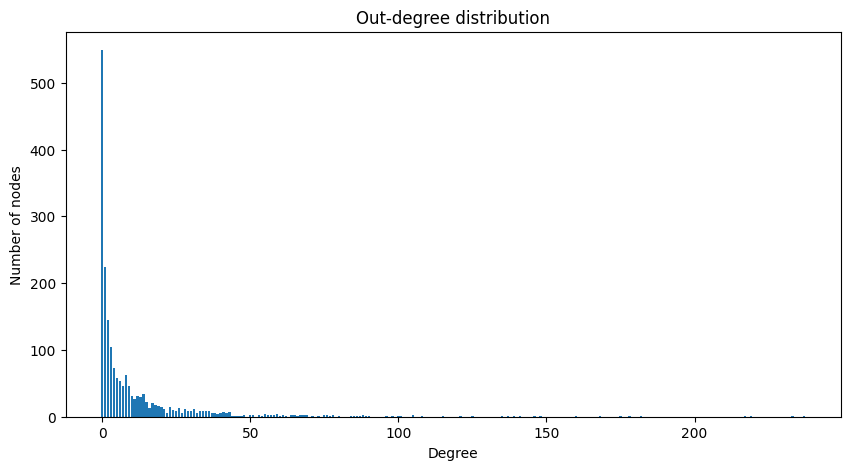

In [21]:
in_degree_distribution = calculate_degree_distribution(raw_data_metrics["degree_distribution"]["in_degree"])
plot_degree_distribution(in_degree_distribution, "In-degree distribution")

out_degree_distribution = calculate_degree_distribution(raw_data_metrics["degree_distribution"]["out_degree"])
plot_degree_distribution(out_degree_distribution, "Out-degree distribution")

### Centrality indices

In [22]:
def plot_centrality_distribution(centrality: dict, title: str, bins=50):
    plt.figure(figsize=(10, 5))
    plt.hist(centrality.values(), bins=bins)
    plt.title(title)
    plt.xlabel("Centrality")
    plt.ylabel("Number of nodes")
    plt.show()

### in-degree centrality

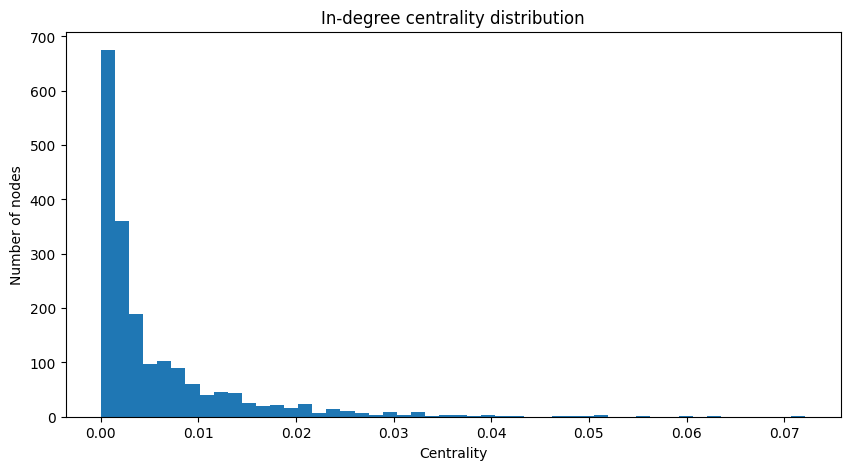

In [23]:
plot_centrality_distribution(raw_data_metrics["centrality"]["in_degree"], "In-degree centrality distribution")

### out-degree centrality

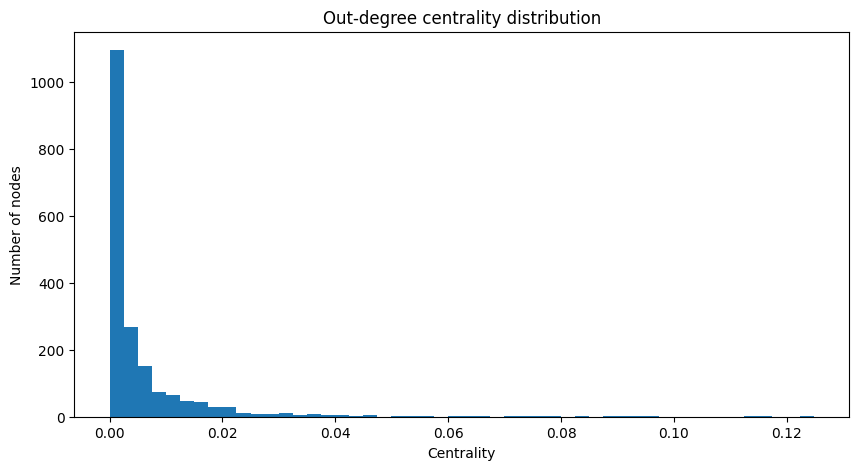

In [24]:
plot_centrality_distribution(raw_data_metrics["centrality"]["out_degree"], "Out-degree centrality distribution")

### closeness centrality

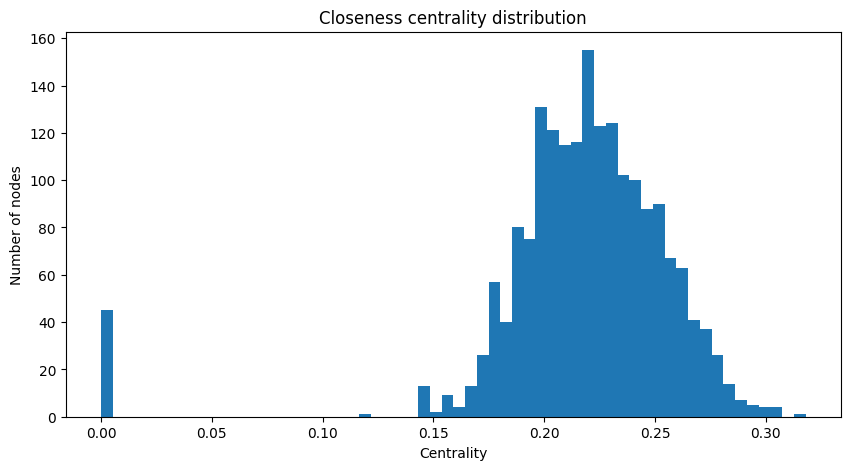

In [25]:
plot_centrality_distribution(raw_data_metrics["centrality"]["closeness"], "Closeness centrality distribution", bins=60)

### betweenness centrality

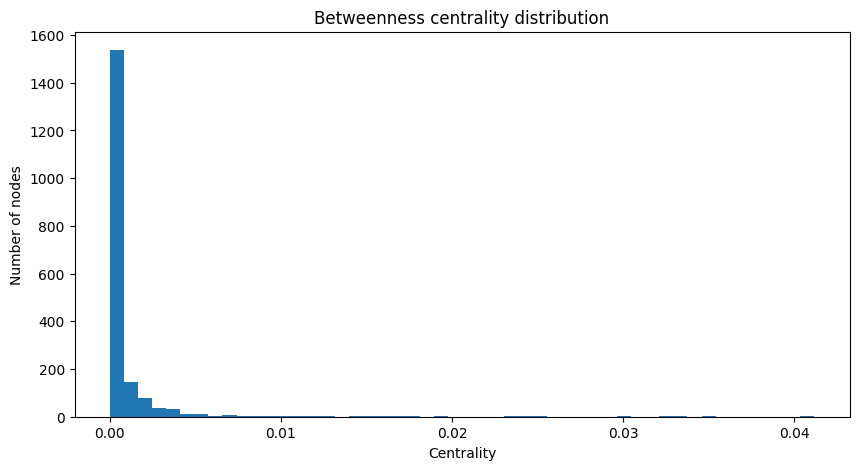

In [26]:
plot_centrality_distribution(raw_data_metrics["centrality"]["betweenness"], "Betweenness centrality distribution", bins = 50)

### Clustering coefficient

In [27]:
print(f"Clustering coefficient: {raw_data_metrics['clustering_coefficient']}")

Clustering coefficient: 0.08723899580135272


### Network diameter

In [28]:
print(f"Network diameter: {raw_data_metrics['diameter']}")

Network diameter: inf


### Density

In [29]:
print(f"Density: {raw_data_metrics['density']}")

Density: 0.005631048674611617


### Connected components

In [30]:
print(f"Number of connected components: {raw_data_metrics['connected_components']}")

Number of connected components: {'number': 4, 'sizes': [1893, 2, 2, 2]}


## Identify groups and their structure
Identify:
▪ Cliques
▪ Homophily analysis (not possible due to all the nodes being of the same type)
▪ Important nodes acting as Bridges
▪ Partitioning Algorithm: Girvan-Newman

In [33]:
raw_data_groups = {}
raw_data_groups["cliques"] = list(nx.find_cliques(raw_data_graph.to_undirected()))
raw_data_groups["bridges"] = list(nx.bridges(raw_data_graph.to_undirected()))

### Visualize the cliques 
Probably a better idea to do this using Gephi

In [34]:
from tqdm import tqdm

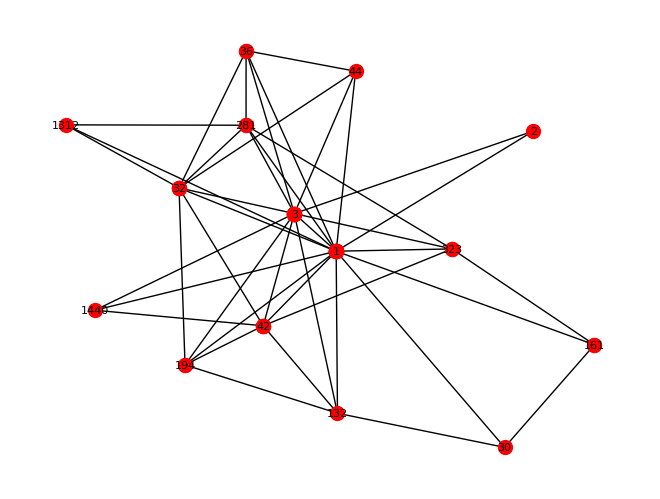

In [35]:
# Sample a subgraph containing some cliques
cliques = raw_data_groups["cliques"]
nodes_in_cliques = set(node for clique in cliques[:10] for node in clique)
subgraph = raw_data_graph.to_undirected().subgraph(nodes_in_cliques)

# Draw the subgraph
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, node_size=50, with_labels=False)
nx.draw_networkx_labels(subgraph, pos, font_size=8)

# Highlight cliques
for clique in cliques[:10]:
    nx.draw_networkx_nodes(subgraph, pos, nodelist=clique, node_color='r', node_size=100)

plt.show()

### Visualize the bridges
Once again probably better with Gephi

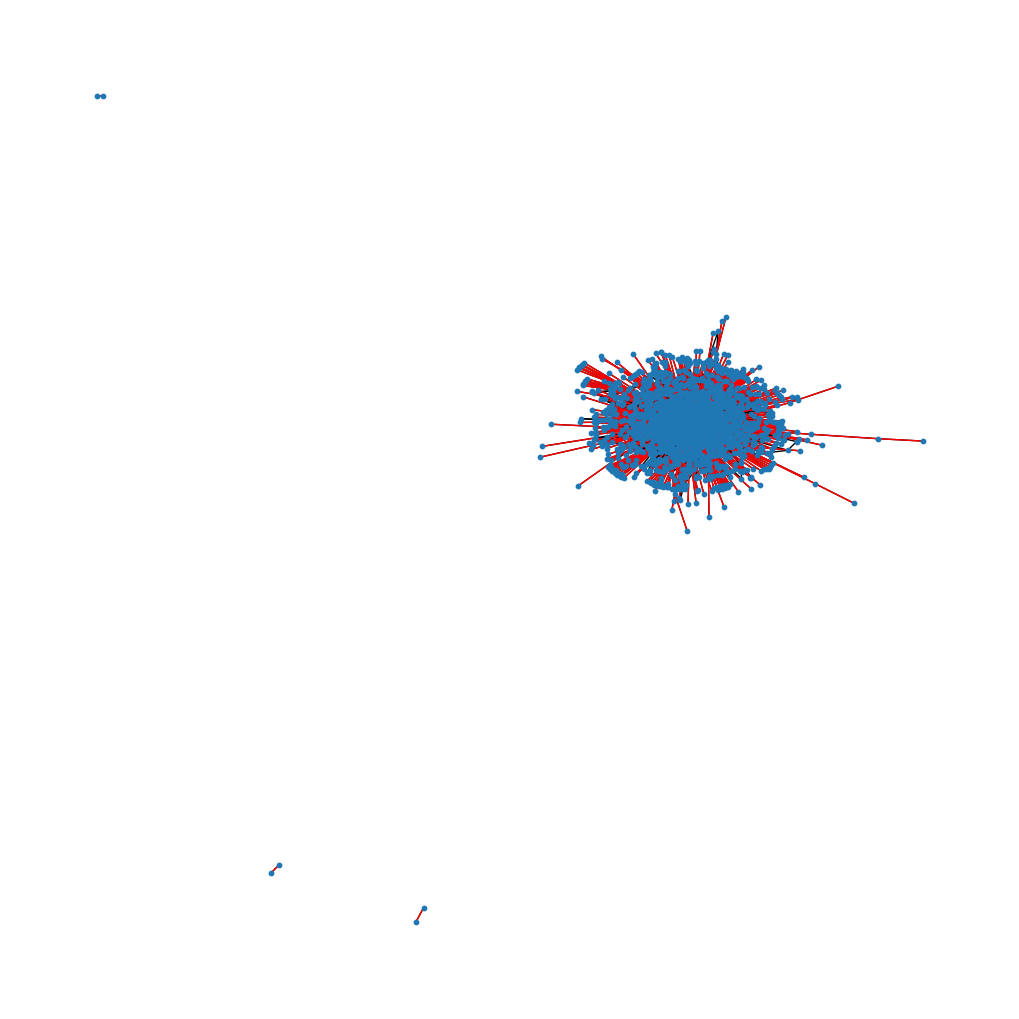

In [36]:
def visualize_bridges(graph: nx.Graph, bridges: list[tuple[int, int]]):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=False, node_size=10)
    nx.draw_networkx_edges(graph, pos, edgelist=bridges, edge_color='r', width=1)
    plt.show()

visualize_bridges(raw_data_graph.to_undirected(), raw_data_groups["bridges"])

### Girvan-Newman algorithm
Get the top k garvin-newman partitions. 
WARNING: This is a very slow process

In [37]:
from networkx.algorithms.community import girvan_newman
import itertools

def girvan_newman_partition(graph: nx.Graph, k: int):
    return list(itertools.islice(girvan_newman(graph), k))

# Change this to a smaller number for faster results
number_of_partitions = 4

raw_data_partitions = girvan_newman_partition(raw_data_graph.to_undirected(), number_of_partitions)

# Questions

1. How does user messaging activity change over time, and what are the periods of peak activity?
2. Who are the most influential users in terms of message spread, and how does influence change over time?
3. What communities exist within the network, and how do they evolve over time?
4. What is the level of reciprocity and echo chambers in the network?
5. How does the network’s structure impact the speed and extent of information spread?


## What is the level of reciprocity? 

In [39]:
nx.overall_reciprocity(raw_data_graph)

0.6363815530153725

In [44]:
# Find a giant component
giant_component = max(nx.connected_components(raw_data_graph.to_undirected()), key=len)

# Draw the giant component
giant_graph = raw_data_graph.subgraph(giant_component)

draw_graph(giant_graph)


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001AE762EB9C0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



Error in callback <function flush_figures at 0x000001AE7630E660> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
# draw a agraph of reciprocity of the giant component
reciprocity_graph = nx.overall_reciprocity(giant_graph)
draw_graph(reciprocity_graph)